In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

from PIL import Image
import helper_functions
from scipy.special import erf

# Vision Transformer

This project explores and reimplements the seminal deep learning paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". The paper can be found at [arxiv](https://arxiv.org/abs/2010.11929).

### Significance

Why is this paper important?

For a long time, different problem domains in deep learning required specialized neural network architectures. In computer vision, convolutional neural networks (CNNs) were the state-of-the-art, while recurrent neural networks (RNNs) dominated sequence processing tasks. However, the Transformer architecture has emerged as a versatile solution, demonstrating its ability to be adapted across a variety of domains and outperforming previous state-of-the-art models. The paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" was one of the first successful applications of the Transformer to image data, marking a significant shift in the way deep learning models are used for visual tasks.

### Challenges

Why was adapting the transformer to image data difficult?

Transformers were originally designed for sequential data, while images are inherently spatial, not sequential. This fundamental difference required significant adaptations. At the core of the Transformer is the attention mechanism, where the computation scales quadratically with the number of input elements. This creates a bottleneck: the size of the Key/Query matrix. For example, with 10 elements, the matrix is 10x10, requiring 100 dot products to be computed.

When applied to images, particularly at the pixel level, this becomes a major challenge. A standard 224x224 image with 3 color channels contains 50,176 pixels. If each pixel attends to every other pixel, this results in 50,176² dot products per attention head. Such computations performed many times are too demanding even for modern data centers.

To address this, various modified attention mechanisms were proposed, such as limiting attention to local neighborhoods. However, these alternatives were not as optimized for GPU execution as the original attention mechanism, and their performance remained less compelling.

Another significant challenge is that Transformers had to compete with a well-established and powerful architecture in computer vision: Convolutional Neural Networks (CNNs). CNNs have two key inductive biases that help them excel in vision tasks:

* Translational Equivariance: A convolutional kernel scans the entire image, allowing the model to detect patterns (e.g., a cat) regardless of their position in the image.
* Locality: The small size of the kernel ensures the model is sensitive to local patterns (e.g., edges, textures).

The authors of the paper argue that because Transformers lack these built-in biases, they require much more data to learn effective representations, making them less efficient for vision tasks without sufficient training data.

### Solutions

How did the authors solve those challenges?

To address the computational bottleneck of the attention mechanism, the paper proposes splitting the image into fixed-size patches and applying the attention mechanism to these patches instead of individual pixels. By carefully selecting the patch size, the authors significantly reduce the computational cost, enabling the use of the standard attention mechanism while keeping it feasible for large images.

To tackle the lack of inductive biases in the Transformer, the authors trained their model on a massive dataset of 300 million images. This large-scale pretraining allows the model to learn effective representations without the need for built-in biases, such as translational invariance and locality, which are inherent in CNNs. As a result, the Transformer model can still achieve impressive performance on vision tasks, even without these inductive biases.

### Method Overview

In this section, we will briefly outline the data processing and model architecture used, which will be explored in greater detail during the reimplementation.

Each image is split into 16x16 pixel patches, which are then linearly embedded into a latent space of size 768. This results in a tensor of shape [batch size, number of patches, 768] (batch, patch, embedding dimensions). A learnable class token is prepended to the tensor, adding an extra patch at the beginning. This idea is inspired by the BERT model (BERT paper).

Next, a learnable position embedding is added element-wise to the tensor, providing spatial information about the patches. Finally, the resulting tensor is fed into a standard Transformer Encoder architecture. For classification, the final state of the class token is used as the output.
Several models of different size were trained in a supervised fashion. First, the models were pre-trained on a large dataset and then fine-tuned on smaller dataset for a specific downstream task.

### Key Points of the Paper

* One key element of the paper is figure 1 (shown below). It shows a high level overview of the data preprocessing and model architecture that were used. 

![Figure 1](data/figure_1.png)

* Another key point are the equations shown in section 3.1 of the paper(shown below). These equations formalize the approach in mathematical notation.

![Key equations](data/equations_3_1.png)

#### Equation 1
$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

This equation shows how the image data is prepared before being fed to the model. Here, 
* $\mathbf{z}_{0}$ is the input of the Transformer Encoder, 
* $\mathbf{x}_\text {class }$ is the prepended class token, 
* $\mathbf{E}$ is the embedding dimension for the image patches, its dimensions are shown on the right
* $\mathbf{x}_{p}^{1}\mathbf{E}$ is the embedding for the first patch, $\mathbf{x}_{p}^{2}\mathbf{E}$ the one for the second and so on.
* $\mathbf{E}_\text {pos }$ is the learnable position embedding

Translated into pseudocode this equation would look like this:<br>
x_input = [class_token, embedding_of_patch_1, embedding_of_patch_2, embedding_of_patch_3...] <br>+ <br>[class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

The patch embedding weights and biases, the prepended class token and the position embeddings are all learnable paramaters (requires_grad = True).

#### Equation 2
$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

The second equation describes the first block of the Transformer Encoder model - the layer norm layer and Multihead Attention layer with a residual connection. For each layer from 1 to 𝐿, where 𝐿 is the total number of layers in the model, the input is first passed through a LayerNorm (LN) layer. Then, the output of the LayerNorm is fed into a Multi-Head Attention (MSA) layer. The input of the layer (before the LayerNorm) is added to the output of the MSA layer, forming a residual connection.
Pseudocode for this equation:<br>
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

#### Equation 3
$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

This equation describes the second part of the Transformer Encoder.For each layer from 1 to L the output of the layers described in equation 2 is first passed to another LayerNorm (LN) layer and the output of the Layer norm is fed to a Multilayer Perceptron. At the end, there is again a residual connection(the input of these two layers is added to the output).
In pseudocode it could be described like this:<br>
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

#### Equation 4
$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

This equation explains that the output of the Transformer Encoder - the zero index element (the  prepended learnable class token) is passed through a another LayerNorm (LN) layer.<br> and fed to a MLP classification head.<br>
y = MLP(LayerNorm(x_output[0]))

### Results TO DO

### Re-implementation

####  Known Hyperparameters of The Vision Transformer

In order to start reimplementing the paper we will need the hyperparameters of the  of the smallest Vision Transformer (ViT-B/16) model from the paper. For now, we will simply list the hyperparameters below and will explore what they mean as we develop the building blocks of the model:

* Size of the embedding dimension: 768
* Number of attention heads in the MSA block: 12
* Number of layers(how many times the Transformer Encoder block is repeated):  12
* Size of the feed-forward dimension (how many units between the two linear layers): 3072
* Where dropout was used:  after the attention and in the feed-forward networks within the transformer layers
* Dropout setting: p = 0.1
* Patch size: 16 X 16 pixels

#### Visualizing Splitting into Patches

Let us start by visualizing an image split into patches:

In [2]:
# Open the image
image = Image.open("data/cat.jpg")

# Resize image to 224 X 224
image_resized = image.resize((224, 224))

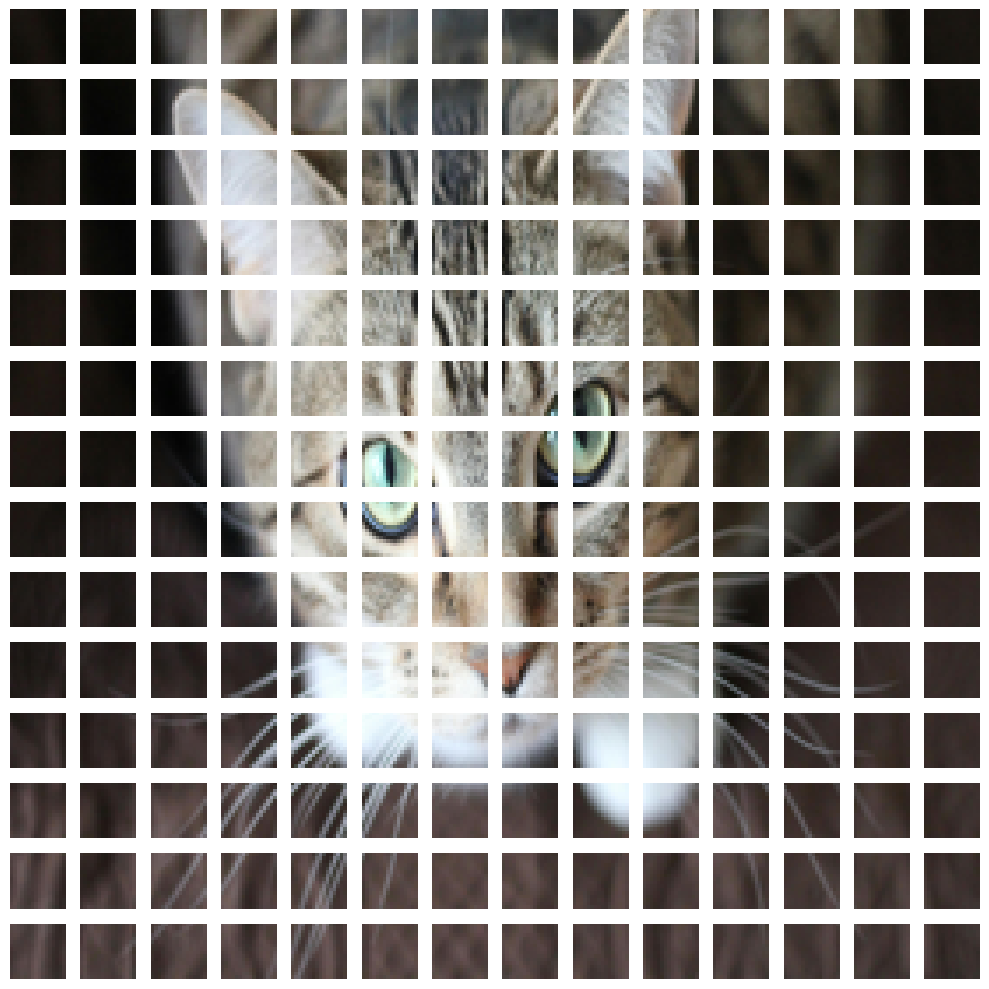

In [3]:
# Show image split into patches
helper_functions.show_image_split_into_patches(image_resized, 16)

#### Embedding patches

We will focus on implementing the smallest model from the paper, where the embedding dimension is 768.

Our first goal is to transform the input tensor from its initial shape to its final shape:

* __Initial shape: (batch_size, channels, height, width)__, where:
    * batch_size represents the batch dimension, and
    * channels is the number of channels in the image
    * height and width are the spatial dimensions of each image.
   
* __Final shape: (batch_size, num_patches, embedding_dim)__, where:
    * batch_size is the batch dimension, 
    * num_patches is the total number of patches extracted from each image, and
    * embedding_dim is the flattened dimension of each patch.

To extract a patch we will use a convolution where the kernel size is equal to the patch size and the stride is equal to the patch size. In this way we will essentially "scan" the input image by moving the kernel over each patch. In order to match the size of the embedding dimension for our model, we will set the out_channels equal to the embedding dimension(768).
From there two approaches are possible:
* Use a flatten layer (`torch.nn.Flatten()`)  to flatten the spatial and channels dimensions.
* Use view (`torch.Tensor.view()`) to reshapes the tensor into the desired shape by specifying its dimensions 

Flattening is maybe more intuitive, but using view offers more control and performance benefits, at the cost of more possibility for mistakes (especially shape mismatches). We will opt to use view. We will also need to permute the dimensions of the tensor to achieve the desired order of dimension.

This can also be achieved without using a convolutional layer by combining reshaping, flattening, and a learnable fully connected (linear) layer. It is important to note that the convolutional layer is used solely for convenience, as it simplifies the process of extracting patches and embedding them linearly (since a convolution is a linear operation). This does not change the architecture because the underlying operation remains a linear transformation that maps the flattened patch into the embedding space, which is the same functionality achieved with a fully connected layer. The Vision Transformer still relies on self-attention mechanisms and does not incorporate the spatial hierarchies typically found in convolutional networks.

With all this in mind let us implement the PatchEmbedding class below:

In [4]:
class PatchEmbedding(nn.Module):
    """
    Convert an input image into a 1D vector of learnable embeddings.

    Parameters:
        in_channels (int): The number of color channels in the input image. Default is 3.
        patch_size (int): The size of each patch to extract from the input image. Default is 16.
        embedding_dim (int): The size of the embedding dimension. Default is 768.

    Returns:
        torch.Tensor: A tensor representing the image as a sequence of learnable embeddings.
    """
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        self.conv = nn.Conv2d(in_channels = in_channels,
                              out_channels = embedding_dim, 
                              kernel_size = patch_size,
                              stride = patch_size,
                              padding = 0)
        
    def forward(self, x: torch.Tensor):
        # Apply convolution to extract patches
        x = self.conv(x)

        # Get the shape for view
        bs, c, h, w = x.shape
        #print(f"Shape after convolution: {x.shape} [batch_size, channels, height, width]") # check shape for debugging purposes

        # Rearrange shape to get [batch_size, height, width, embedding_dim]
        x = x.permute(0, 2, 3, 1)
        #print(f"Shape after permute: {x.shape} [batch_size, height, width, embedding_dim]")  # check shape for debugging purposes

        # Reshape to [batch_size, num_patches, embedding_dim] where num_patches = h * w
        x = x.view(bs, h * w, c)  # Shape will be (batch_size, num_patches, embedding_dim)
        #print(f"Shape after view: {x.shape}")  # check shape for debugging purposes
        
        return x

In [5]:
image_path = "data/cat.jpg"
image = Image.open(image_path)

# Define a transform to convert the image to a tensor and normalize it
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply the transform to the image
image_tensor = transform(image)

# Convert the tensor to float32 (if not already)
image_tensor = image_tensor.to(torch.float32)

# Add batch dimension
image_tensor = image_tensor.unsqueeze(dim = 0)

# Check image shape
print(f"Input shape is: {image_tensor.shape} [batch_size, channels, height, width]")

Input shape is: torch.Size([1, 3, 224, 224]) [batch_size, channels, height, width]


In [6]:
# Test the PatchEmbedding class on the sample image
patch_embedding_layer = PatchEmbedding()
patch_embedded_image = patch_embedding_layer(image_tensor)

We have embedded the image patches and achieved the desired shape. Now we can look into implementing the prepended class token and the position embedding.

#### Class Token Embedding

The class token embedding essentially is another patch that does not exist in the original image  and is created by us and added at the beginning of the tensor for the patch-embedded image. Its dimensions are the same as those of the patch embeddings (1, 768). To create the token we can use `nn.Parameter()` in PyTorch. 

In [7]:
# Get batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[2]

# Create class token
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad = True) # make embedding learnable

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [8]:
# Concat the class token to the patch embedded image
patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1) # concat on the number of patches dimension

# Show resulting shape
print(f"The shape of the patch embedded image with a prepended class token is {patch_embedded_image_with_class_token.shape} [batch_size, number_of_patches, embedding_dimension]")

The shape of the patch embedded image with a prepended class token is torch.Size([1, 197, 768]) [batch_size, number_of_patches, embedding_dimension]


We can see that the size of the number of patches dimension increased by one - we have added an extra patch (the class token.)

#### Position Embedding

Position embeddings are added to patch embeddings to enable the model to capture and retain positional information. These embeddings are not inherently tied to the physical positions of the patches in the image; instead, they are fully learned by the model during training.

Position embeddings have the same shape as the patch-embedded image, including the prepended class token, and are added element-wise. They enable the model to adjust the representation of the patches and the class token to account for positional information. To create them we can again use `nn.Parameter()` with the required shape.

In [9]:
# Get number of patches dimension:
num_patches_dim = patch_embedded_image_with_class_token.shape[1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             num_patches_dim,
                                             embedding_dimension),
                                             requires_grad = True) # make sure it's learnable

# Add the learnable 1D position embedding to the patch embeddings and the class token
model_input = patch_embedded_image_with_class_token + position_embedding
print(f"Shape of the input for the model after all embeddings: {model_input.shape} [[batch_size, number_of_patches, embedding_dimension]]")

Shape of the input for the model after all embeddings: torch.Size([1, 197, 768]) [[batch_size, number_of_patches, embedding_dimension]]


Since we are simply adding two tensors element-wise the dimension before and after stay the same.

#### The Transformer Encoder

Having successfully split an image into patches, embedded them, prepended a learnable class token and added learnable position embeddings we are ready to feed the transformed data to the heart of the vision transformer model - the transformer encoder.

![The Transformer Encoder (source: ViT paper)](data/transformer_encoder.jpg)

Mathematically the transformer encoder can be viewed as the input of  equation 2 from earlier  $$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}\end{aligned} $$
fed into eqution 3 
$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}\end{aligned} $$
as many times as the number of transformer layers (referred to as "L" in the paper).<br><br>
Encoder Structure:
The transformer encoder consists of two main blocks, each enclosed by a residual connection:

* Multi-head Self-Attention (MSA) Block with a residual connection:
    * A Layer Norm layer.
    * A Multi-head Self-Attention layer.
* Multilayer Perceptron (MLP) Block with a residual connection:
    * A Layer Norm layer.
    * A Multilayer Perceptron layer.
    
Let us discuss these components below.

#### Transformer Encoder Block I

##### Residual Connections

Residual connections allow the input of a layer or a block of layers to be directly added to the output. Mathematically, if the function mapping the input to the output is $f(x)$, the residual connection produces $f(x)+x$. The primary purpose of residual connections is to improve training dynamics and enable the training of deeper networks with many hidden layers.

Historical Context:

Historically, researchers observed that simply increasing the size of a network (by adding layers) often led to worse performance, even when the general architecture remained the same. This behavior was counterintuitive since a larger network should, in theory, be at least as capable as a smaller one. The larger network could, for example, replicate the smaller network's behavior by learning the identity function in the additional layers available.

This observation inspired the introduction of residual connections, which allow a block of layers to start learning from an easy and known starting point - the identity function. By providing a straightforward initialization, residual connections mitigate the challenges of optimizing very deep networks.

Benefits in Backpropagation:

Residual connections also improve the flow of gradients during backpropagation. When the upstream gradient flows through the addition operation (the "add gate"), it is distributed equally to the input and the residual path. This ensures that gradient information flows more freely through the network, making it easier to train deeper architectures. This improved gradient flow helps prevent the vanishing gradient problem, which is often a major issue in training very deep networks.

We can implement residual connections in the forward methods of the classes for the blocks that use it.

##### Layer Norm

A Layer Normalization (Layer Norm) layer performs z-score normalization across the feature dimension for each sample (in our case, the embedding dimension). The primary purpose of layer normalization is to facilitate training by reducing the risk of vanishing or exploding gradients. By stabilizing the gradients, it promotes faster convergence and improves the consistency of the training process.

Key Differences Between Layer Norm and Batch Norm:
* Normalization Scope:

    * Layer Norm: Normalizes across the feature dimension for each individual sample.
    * Batch Norm: Normalizes across the batch dimension.
* Dependence on Batch Statistics:

    * Layer Norm: Does not rely on batch statistics, making it well-suited for tasks where batch sizes are small or vary, such as sequence modeling.
    * Batch Norm: Relies on batch statistics, which can be problematic in scenarios with small or irregular batch sizes.
    
Advantages of Layer Norm:<br><br>
By avoiding dependence on batch statistics, layer norm provides consistent normalization regardless of batch size, making it particularly useful in architectures like transformers and recurrent networks where sequential inputs or varying batch sizes are common.

Layer normalization can be is implemented in PyTorch by the `torch.nn.LayerNorm` class.

##### Multi-Head Self Attention

###### Single-head Attention

The attention mechanism is the core of the Transformer model. It operates on sets of elements, enabling each element to exchange information with all others. Each element "broadcasts" its information to the rest while simultaneously "inquiring" about what others have to offer. These inquiries are called queries, and the responses from other elements are referred to as keys. Based on this exchange, each element is updated using a weighted combination of information from the others, with the weights applied to these values, representing the content being shared.

In more strict mathematical terms the attention mechanism is described by the following equation:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V
$$

where $Q$ and $K$ are the queries (inquiries) and keys (responses).

To compute the attention mechanism in a single attention head, we first project the input into three matrices: Queries, Keys, and Values. These projections are done using learnable weights and biases.

Next, we calculate the dot product between each pair of Queries and Keys. This can be visualized by constructing a matrix where the size is determined by the query and key dimension. Such a matrix is also called Attention Score Matrix. Each element of this matrix is filled with the result of the corresponding dot product. This is the reason why the number of operations in the attention mechanism grows quadratically with the number of input elements.
The dot product results are then scaled by $\sqrt{d_k}$, where $d_k$ is the dimension of the Queries and Keys. This scaling is crucial for improving numerical stability during computation.

After scaling, the softmax function is applied to the dot products. The softmax function is defined as:
$$\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$$
This converts the scaled dot products into probabilities, where each value represents how much attention should be paid to the corresponding Key.

Finally, these probabilities are used to weight the Values matrix. This results in a weighted sum of the values, which is the final output of the attention mechanism.

###### Masked Attention

In natural language processing (NLP), particularly in GPT-based models, a special type of attention called Masked Self-Attention is used.

Masked Self-Attention modifies the query-key dot product matrix by masking out certain elements, effectively using only half of the attention score matrix. This masking ensures that tokens cannot attend to future tokens. The purpose is to prevent later words from influencing earlier words in the model's output. Without masking, the model could "cheat" during training by using information from tokens that would not be available during inference.

The masking is achieved by setting specific cells in the attention score matrix to $-\infty$, before applying the softmax function. This ensures that the masked positions receive a probability of zero after the softmax operation, effectively ignoring the corresponding elements in the value matrix during the attention computation.


In our case, the tokens are the patch embeddings. However, since the ViT (Vision Transformer) is not an autoregressive generative model, but rather a classification model, we do not need Masked Self-Attention. Instead, we want each patch embedding to attend to all other patch embeddings.

###### Multi-Head Attention

So far, we have only discussed Single-Head Attention. In Multi-Head Attention, the same computations as in Single-Head Attention are performed, but the input is split across the embedding dimension based on the number of heads. Each attention head has its own set of weight matrices for the Query, Key, and Value transformations. After each head computes its attention, the outputs of all heads are concatenated along the embedding dimension, preserving the shape of the tensor through the Multi-Head Attention layer.
This approach has several important benefits:
* Parallelization - Since each head performs its calculations independently, they can be run in parallel, improving computational efficiency.
* Ability to capture diverse relationships: Each attention head "sees" a different part of the input and has its own set of weights, enabling it to learn different types of relationships within the data. For example, one head might focus on short-range dependencies between tokens, while another might capture long-range dependencies.
* Enhanced Representation: Multi-Head Attention allows the model to aggregate a wider range of features from the input sequence, capturing a more comprehensive understanding of the data.
* Improved Model Capacity: With multiple heads, the model can explore more complex relationships within the input, leading to better performance in tasks that require nuanced, contextual understanding.

So far we have focussed on the first part of the Transformer Encoder - the one corresponding to equation 2 from the paper:
$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$ 
As discussed, it consists of a layer norm layer and a Multi-Head Attention layer with a residual connection. Lets implement them in Pytorch:

In [10]:
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a Multi-Head Self Attention block
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0):
        super().__init__()

        # Create Layer Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        # Create the Multi-ead Self Attention layer
        self.multhihead_attention = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                          num_heads = num_heads,
                                                          dropout = attn_dropout,
                                                          batch_first = True)

    def forward(self, x):
        # Apply LayerNorm to input x
        normed_x = self.layer_norm(x)

        # Perform Multi-Head Attention
        attn_output, _ = self.multhihead_attention(query = normed_x,
                                                   key = normed_x,
                                                   value = normed_x,
                                                   need_weights = False)
        # Implement the residual connection
        x = x + attn_output

        return x

In [11]:
# Print out shape of input for the Transformer Encoder model
print(f"Shape of model input: {model_input.shape} [batch_size, number_of_patches, embedding_dimension]")

# Create an instance of MSA block
multi_head_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim = 768,
                                                              num_heads = 12)
# Pass the model input to MSA block
model_input_through_block_1 = multi_head_self_attention_block(model_input)
print(f"Shape of the output of the Transforer Encoder block I: {model_input_through_block_1.shape} [batch_size, number_of_patches, embedding_dimension]")

Shape of model input: torch.Size([1, 197, 768]) [batch_size, number_of_patches, embedding_dimension]
Shape of the output of the Transforer Encoder block I: torch.Size([1, 197, 768]) [batch_size, number_of_patches, embedding_dimension]


As we can see the shape of the input of the block is preserved in its output.

#### Transformer Encoder Block II

##### The Multilayer Perceptron Block

The second part of the Transformer Encoder - the Multilayer Perceptron block corresponds to equation 3 from the paper: 
$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

As previously discussed the Multilayer Perceptron (MLP) Block with a residual connection consists of:
* A Layer Norm layer.
* A Multilayer Perceptron layer.

Again a Layer Norm layer is used to normalize the inputs to the block, and then the result is passed to the Multilayer Perceptron layer. The MLP layer is essentially a vanilla neural network and also sometimes called linear layer, fully connected layer or dense layer. In the vision transformer architecture, two linear layers are separated by the GELU non-linearity. Additionally, after each linear layer dropout is applied to reduce overfitting. We have alreay looked at residual connections and the Layer Norm layer, the rest of the elements of the MLP block we will discuss in detail below. We wil briefly look at the ReLU non-linearity first as a building block for the popular for Trasformers GeLU non linearity.

###### The RELU Non-Linearity

The ReLU function is defined as:
$$Relu(z) = max(0, z)$$

The Rectified Linear Unit function(ReLU) activation function is simple and very fast to compute. For example, one could imagine only looking at the most significant bit to determine the output. However, its flat region for negative inputs can cause the "dying ReLU" problem, where neurons can become inactive and stop learning if their gradient becomes zero. Another problem is the fact that it has sharp non-differentiable point at $x = 0$. In practice, the non-differentiable point in functions like ReLU is rarely an issue. This is because neural networks involve stochasticity, and it's highly unlikely that an input value will be exactly zero. Even if it does happen, this can be handled using the concept of a subgradient.

A subgradient provides a range of possible gradients at a non-differentiable point. In the case of ReLU, this range is from 0 to 1. For negative inputs, the gradient is 0, and for positive inputs, the gradient is 1. The non-differentiable point (at $x=0$) lies between these two values, and the subgradient allows the optimization process to continue without issues. 


Let us define a the ReLU function in code and plot it so we can gain visual intuition about it.

In [12]:
# Define Relu
def relu(x):
    return torch.maximum(torch.tensor(0.0), x)

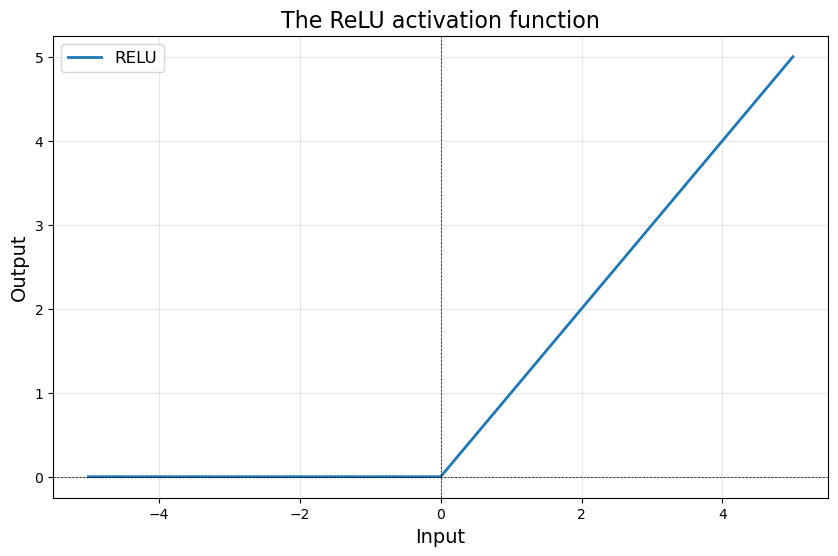

In [13]:
helper_functions.plot_activation_functions((relu, "RELU"), "The ReLU activation function")

###### The GELU Non-Linearity

The Gaussian Error Linear Unit (GELU) is a smooth non-linear activation function. It seeks to he combine the benefits of ReLU and sigmoid-like smoothness. Unlike ReLU, which applies a hard threshold at zero, GELU weights inputs smoothly based on their value, allowing small positive and negative values to have gradients. It is defined as $$Gelu(x) = x\Phi(x)$$
Here $\Phi(x)$ is the cumulative distribution function (CDF) of a standard Gaussian distribution. The CDF of a standard normal distribution,  $\Phi(x)$ is defined as:
$$\Phi(x)={\frac{1}{\sqrt{2\pi}}}\int_{-\infty }^{x}e^{-t^{2}/2}\,dt$$

This integral expression corresponds to the area under the curve of the standard normal distribution from negative infinity ($-\inf$) to $x$. $\Phi(x)$ represents the cumulative probability up to the point $x$ on a standard normal distribution. For example, if $x = 0$, then $\Phi(x) = 0.5$ meaning there is a 50% chance that a standard normal variable will take a value less than or equal to 0. Below we plot the standard normal distribution ($\mu = 0$ and $\sigma = 1$) and the area up to $x$ to visualize this example.

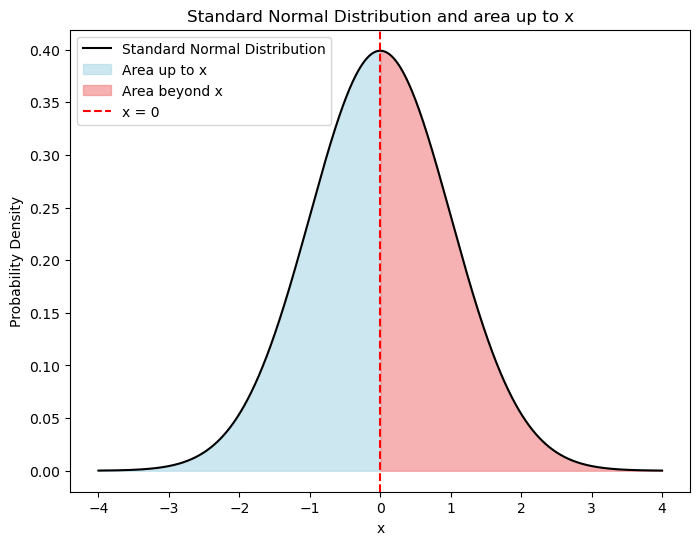

In [14]:
helper_functions.plot_normal_distribution(0)

In essence, by using $\Phi(x)$ GELU introduces a probabilistic and smooth thresholding mechanism. Instead of applying a sharp cutoff as in ReLU, GELU scales the input $x$ by a value that reflects how much of the normal distribution's area lies to the left of $x$, resulting in a smooth, non-linear transformation. This smoothness helps prevent issues like the "dying ReLU" problem, where neurons become inactive and stop learning.
$\Phi(x)$ can also be expressed by the error function, because the error function calculates the area under the Gaussian curve from $0$ to $x$ so it can be transformed into the CDF of the standard normal distribution by scaling the input:
$$\Phi (x)={\frac{1}{2}}\left[1+\mathrm{erf}\left({\frac {x}{\sqrt{2}}}\right)\right]$$

Both these equivalent formulations contain an integral expression and can be expensive to compute in practice. This is why often an approximation is use. An approximate value can be computed with the expression:$$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left( 1 + \tanh\left( \sqrt{\frac{2}{\pi}} \cdot \left( x + 0.044715 \cdot x^3 \right) \right) \right)$$


Below we define the error function formulation of GELU and the approximation formulation in python to be able to plot both and explore them visually.


In [15]:
def gelu(x):
    return 0.5 * x * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

def gelu_approx(x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * x**3)))

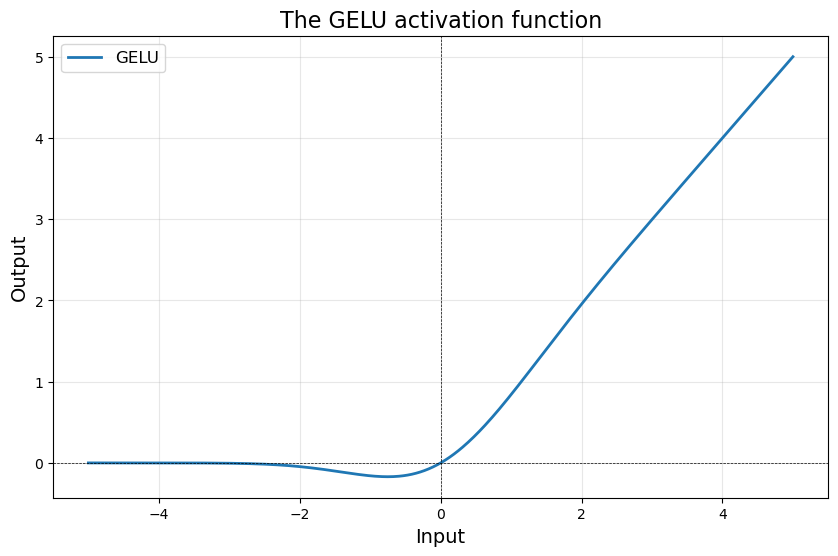

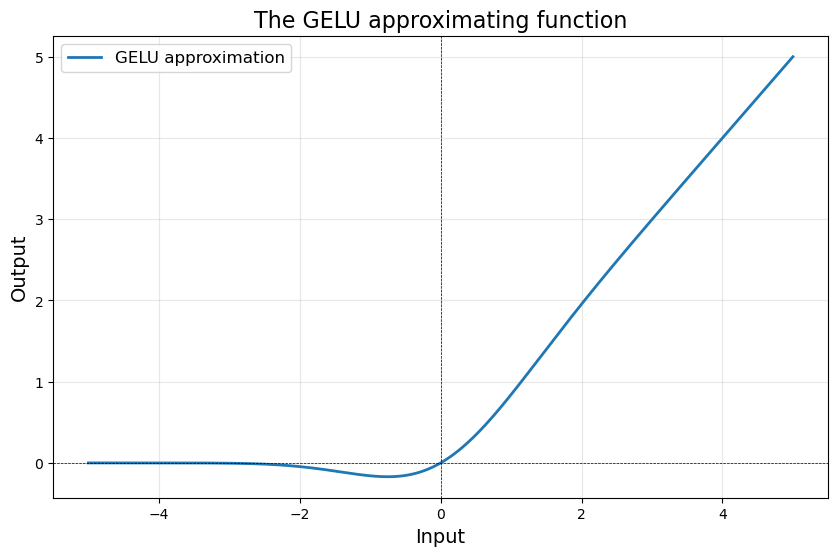

In [16]:
# Plot GELU
helper_functions.plot_activation_functions((gelu, "GELU"), "The GELU activation function")
# Plot GELU approximation
helper_functions.plot_activation_functions((gelu_approx, "GELU approximation"), "The GELU approximating function")


The actual function and the approximation are very close. Next, let us plot Relu and GELU on the same plot for comparison.

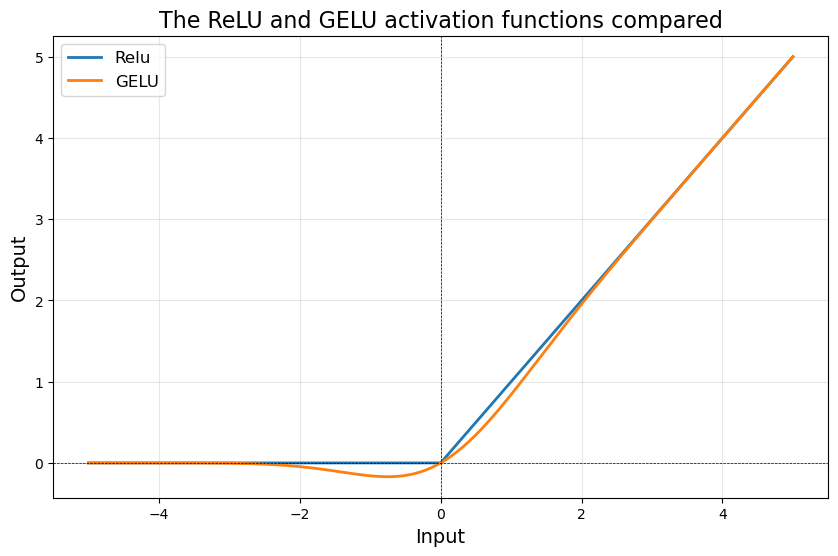

In [17]:
helper_functions.plot_activation_functions([(relu, "Relu"),(gelu, "GELU")], "The ReLU and GELU activation functions compared") 

We can see how GELU smooths out the sharp point in ReLU. This benefit, however comes at a cost - GELU is much more expensive to compute. Even so GELU is very popular choice in the Tranformer architecture. This is because it has several important benefits:
* Smooth Transitions - the smooth transition around zero avoids the hard cutoff of ReLU and the potential "dying neuron" problem. It allows the model to retain small input signals during training, which is particularly useful for capturing nuanced relationships in data.
* Improved Gradient Flow - GELU improves gradient flow for inputs near zero compared to ReLU, which discards all negative inputs. This can lead to faster convergence and more stable training.
* Probabilistic Interpretation - the function’s design, based on the Gaussian error function, has a probabilistic interpretation. It weighs inputs by their likelihood of being activated, which aligns well with the probabilistic nature of self-attention mechanisms in transformers.
* Empirical Results - GELU has been shown to perform better than ReLU and similar functions (like LeakyReLU) in large transformer architectures (e.g., BERT, GPT, and Vision Transformers), leading to improved training stability and accuracy.

Both the ReLU and GELU activatioin functions are readily available in PyTorch: `torch.nn.ReLU` and `torch.nn.GELU. 

###### Dropout

Dropout is a regularization technique used in deep learning to prevent overfitting and improve the generalization ability of the network. It works by randomly "dropping out" or deactivating a fraction of the unints in a layer during each training step, meaning that those units don't contribute to the forward pass or backpropagation for that particular iteration. This forces the network to learn redundant representations, which helps improve robustness. 

One way to gain intuition about dropout is to think of the training process as training not just one main network, but several subnetworks. During each training step, different subsets of units are randomly deactivated, effectively creating a different subnetwork each time. The outputs of these subnetworks are then averaged. This approach helps with generalization because each subnetwork is likely to overfit the data in a different way. By averaging the results, we reduce the influence of individual biases, leading to a more robust model.
Dropout can be implemented in PyTorch with `torch.nn.Dropout`,and the probability for each unit to be deactivated can be set with the `p` parameter.

Having explored the building blocks, let us implement the second part of the Transformer Encoder - the Multilayer Perceptron block in code.

In [18]:
class MLPBlock(nn.Module):
    """ 
    Creates a multiLayer perceptron block.
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 dropout: float = 0.2):
        super().__init__()

        # Create the Layer Norm layer
        self.layer_norm = torch.nn.LayerNorm(normalized_shape = embedding_dim)

        # Create the Linear layers
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                      out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = mlp_size,
                      out_features = embedding_dim),
                      nn.Dropout(p = dropout)       
        )

    def forward(self, x):
        normed_x = self.layer_norm(x)
        mlp_output = self.mlp(normed_x)
        # Implement the residual connection
        x = x + mlp_output
        return x

In [19]:
# Create an instance of MLP block
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# Pass the output of block I to block II
model_input_through_block_2 = mlp_block(model_input_through_block_1)
print(f"Shape of output after block 2: {model_input_through_block_2.shape} [batch_size, number_of_patches, embedding_dimension]")

Shape of output after block 2: torch.Size([1, 197, 768]) [batch_size, number_of_patches, embedding_dimension]


Again as with block I the shape is preserved through block II.

The two building blocks of the Transformer Encoder work in unison to allow the model lear rich and useful representations of its data. 

The first block - the self-attentions mechanism captures relationships or dependencies between elements in its input. However, attention on its own is not enough because other than adjusting how much influence each token has on others it does not perform any significant transformation of the input data. This is because attention relies on linear projections and merely calculates linear combinations of the input features. 
This is were the second block - the multilayer perceptron block comes in. It has the GELU non-linearity and can apply non-linear transformations to its input. This allows the model to capture more complex patterns that cannot be learned by linear operations alone. Additionally, the MLP block increase the capacity of the model.

We will use block I and block II to implement the Transformer Encoder below.

In [20]:
class TransformerEncoderBlock(nn.Module):
    """
    Creates the transformer encoder block 
    """
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0):
        super().__init__()

        # Create MSA block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                     num_heads = num_heads,
                                                     attn_dropout = attn_dropout)

        # Create MLP block
        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                                  mlp_size = mlp_size,
                                  dropout = mlp_dropout) 

    def forward(self, x):
        return self.mlp_block(self.msa_block(x)) # equations 2 and 3

In [21]:
# Create an instance of the transformer encoder block
transformer_encoder_block = TransformerEncoderBlock()

# Print  summary of the Transformer Encoder 
summary(model = transformer_encoder_block,
         input_size = (1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names = ["input_size", "output_size", "num_params", "trainable"],
         col_width = 20,
         row_settings = ["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multhihead_attention)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

For the purpose of acquiring a deeper understanding of the Transformer Encoder we have implemented it using basic blocks. However, it is readily available in PyTorch as `torch.nn.TransformerEncoderLayer()`. From hear on we will use the built-in implementation.

#### The Classifier Head

Once the Transformer Encoder is trained, it is expected to have learned meaningful representations of the input data, enabling it to extract useful features from the input effectively. This is where the prepended class token plays a crucial role.

The class token, prepended to the sequence of patch embeddings, is designed to act as a global representation of the entire input image. As the sequence passes through the Transformer Encoder, the class token interacts with the patch embeddings via self-attention, allowing it to "absorb" information from all patches. By the end of the encoding process, the class token is expected to contain a rich, high-level representation of the image that encapsulates the most important features.

In the final stage, this class token is extracted and serves as the input to the classifier head. The classifier head, typically a fully connected layer, uses the class token to make predictions, such as classifying the image into categories. Essentially, the class token acts as a summary of the entire image, distilled into a single vector that drives the model's final output.

Two different versions of the classifier head were used - one for the pretraining done on a large dataset, and another for fine-tuning the model on a smaller downstream task.
In the fine-tuning head the class tokens are first normalized using a Layer Normalization (LayerNorm) layer. After normalization, they are passed through a Linear layer. The Linear layer has an input size equal to the embedding dimension (the size of the class token) and an output size equal to the number of classes in the classification task.
The classifier head uses for pretraning is the same, but with an extra hidden linear layer. The GELU non linearity was used for activation between the two linear layers.

The output of the classifier head consists of raw logits, where each logit corresponds to a class. These logits represent the unnormalized scores for each class, which can be further processed for example with the softmax function to produce class probabilities.

#### Putting everything together

We have explored and implemented all the building blocks of the Vision Transformer. We can now put everything together to implement the Vision Transformer model. 

In [22]:
class VisionTransformer(nn.Module):
    """
    Creates the Vision Transformer architecture with hyperparameters for ViT base from the paper
    """
    def __init__(self,
                 img_size: int = 224, # Input images dimensions
                 in_channels: int = 3, # Input number of channels
                 patch_size: int = 16, # Patch size
                 num_transformer_layers: int = 12, # How many times input is run through equations 2 and 3
                 embedding_dim: int = 768, # Size of the embedding dimension
                 mlp_size: int = 3072, # Size of the input of the second MLP layer 
                 num_heads: int = 12, # Number of head for Multi-Head Self-Attention 
                 attn_dropout: float = 0 , # Dropout for attention
                 mlp_dropout: float = 0.1, # Dropout for linear layers (MLP)
                 embedding_dropout: float = 0.1, # Dropout for patch and position embeddings
                 num_classes: int = 1000): # Number of outputs for the Classifier head
                 
        super().__init__()
        # Check if image size is divisible by patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # Calculate number of patches
        self.num_patches = (img_size * img_size) // (patch_size * patch_size)

        # Create the learnable class embedding
        self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                            requires_grad = True)
        # Create the learnable position embedding
        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim),
                                               requires_grad = True)
        # Create embedding dropout
        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        # Create the patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                              patch_size = patch_size,
                                              embedding_dim = embedding_dim)
        
        # Create temporary encoder layer for the constructor
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = embedding_dim, # Embedding dimension
            nhead = num_heads,       # Number of attention heads
            dim_feedforward = mlp_size, # Feedforward network size
            dropout = mlp_dropout,      # Dropout in the MLP layer
            activation = "gelu",        # GELU Non-linearity 
            batch_first = True        
        )

        # Create the Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer = encoder_layer,
            num_layers = num_transformer_layers,
            
        )

        # Create the Classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim,
                      out_features = embedding_dim),
            nn.ReLU(),
            nn.Linear(in_features = embedding_dim,
                      out_features = num_classes)

        )

    def forward(self, x):
        # Get batch size
        batch_size = x.shape[0]

        # Create the class token and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Create the patch embedding
        x = self.patch_embedding(x)

        # Prepend the class token embedding
        x = torch.cat((class_token, x), dim = 1)

        # Add the position embedding
        x = self.position_embedding + x

        # Run the embedding dropout
        x = self.embedding_dropout(x)

        # Pass the input batch with prepended class tokens and added 
        # position embeddings through the Transformer Encoder
        x = self.transformer_encoder(x)

        # Run the 0th index element through the classifier hear
        x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

        return x

In [23]:
# Create an instance of the Vision Transformer
vision_transformer_model = VisionTransformer()

# Print input dimensions
print(f"Input dimensions are: {image_tensor.shape} [batch_size, channels, height, width]")

# Pass resized and unsqueezed image to model
vision_transformer_model_output = vision_transformer_model(image_tensor)

# Print shape of output
print(f"Output dimensions are: {vision_transformer_model_output.shape} [batch_size, number of classes]")

Input dimensions are: torch.Size([1, 3, 224, 224]) [batch_size, channels, height, width]
Output dimensions are: torch.Size([1, 1000]) [batch_size, number of classes]


In [24]:
# Print summary for the Vision Transformer
summary(model = vision_transformer_model,
         input_size = (1, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
         col_names = ["input_size", "output_size", "num_params", "trainable"],
         col_width = 20,
         row_settings = ["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                   [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv)                                    [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder)              [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)                 [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    

In [25]:
vision_transformer_model_output

tensor([[-1.2519e-02,  2.2138e-01, -3.1870e-01,  3.8335e-01, -1.0426e-01,
          4.3115e-02, -1.5192e-01, -2.5928e-01,  4.5923e-01,  3.7155e-01,
          1.0338e-01,  1.2395e-01, -3.2863e-01,  5.6961e-02, -3.6442e-01,
          3.2578e-01, -4.3438e-02, -1.5528e-02, -3.1947e-01, -1.0312e-01,
         -2.7538e-01,  1.5347e-01, -7.2195e-02, -1.4525e-01, -2.3744e-01,
         -1.8646e-01, -1.5291e-02, -2.1101e-01,  1.3990e-01,  3.1602e-01,
          3.7119e-02,  4.5136e-01,  3.5770e-01,  1.2584e-01,  1.7715e-01,
         -4.0039e-02,  2.6794e-02, -2.8838e-01,  3.0117e-01,  3.8374e-01,
          1.1716e-01, -1.8170e-01, -8.0999e-02, -1.4389e-01, -1.0477e-01,
          1.7931e-01, -9.5326e-02,  2.2107e-01, -2.0420e-01, -7.8304e-02,
         -3.7803e-01,  1.7445e-01, -2.6977e-01,  1.7247e-01, -1.5221e-01,
          3.3028e-01,  2.7260e-01, -2.4344e-01, -2.6253e-01, -4.8813e-02,
         -4.0391e-01, -4.8719e-02,  2.6223e-01,  7.8122e-02, -1.5515e-02,
         -1.5107e-01,  4.6911e-01, -3.